In [3]:
import sys
sys.path.append('/home/meiri.yoav/biomed_proj/pyPPG')

from Prefiltering import*
from FiducialPoints import*
from Biomarkers2 import*
from Summary import*
from Statistics import*
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
# set seed 42
np.random.seed(42)

Setup:

Input: 10 ppg cycles (each one represented as 1x30 feature vector, total 10x30 matrix)

Output: 0/1 (0: non_af, 1: af)



In [4]:
def sample_series(X, B, series_size):
    n = X.shape[0]
    idx = np.random.randint(0, n-series_size, B)
    onsets = np.zeros(B)
    X_sampled = np.zeros((B, series_size, X.shape[1]-3)) # substracting 3 because we ommit Tpi, sample_idx and os
    for i in range(B):
        X_sampled[i,:,:] = X.iloc[idx[i]:idx[i]+series_size,:].drop(columns=['Tpi', 'sample_idx', 'os'])
        # put in onsets[i] the onset value of the record in idx[i]
        onsets[i] = X.iloc[idx[i],:].os
        
    return X_sampled, onsets, idx


In [5]:
def excract_hrv_features(cycle_signal_30, fs):
    from hrvanalysis.extract_features import get_time_domain_features
    from hrvanalysis.extract_features import get_frequency_domain_features
    from hrvanalysis.extract_features import get_geometrical_features
    from hrvanalysis.extract_features import get_poincare_plot_features
    from hrvanalysis.extract_features import get_csi_cvi_features
    import pandas as pd

    ''' reference: https://aura-healthcare.github.io/hrv-analysis/hrvanalysis.html'''

    time_domain_features = get_time_domain_features(cycle_signal_30)
    frequency_domain_features = get_frequency_domain_features(cycle_signal_30, sampling_frequency=fs)
    # geometrical_features = get_geometrical_features(cycle_signal_30)
    poincare_plot_features = get_poincare_plot_features(cycle_signal_30)
    csi_cvi_features = get_csi_cvi_features(cycle_signal_30)

    # aggregate all features into one dict and turn it into a dataframe
    features = {
                **time_domain_features,
                **frequency_domain_features,
                # **geometrical_features,
                **poincare_plot_features,
                **csi_cvi_features
                }
    features_arr = pd.DataFrame(features, index=[0]).to_numpy()
    return features_arr.squeeze()

def get_outlier_bounds(arr):
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr, 0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return lower_bound, upper_bound


In this setup we trainon sampled 30 cycle long series and test & validate on non-sampled (sliced) 30 cycle long series.

In [6]:
import random
from sklearn.impute import KNNImputer
from hrvanalysis.preprocessing import get_nn_intervals

# B = 100# 1000 10 cycle long samples for each subject
# series_size = 30
# fs = 125
# add_hrv = True
# add_morph = True


# annot_files = sorted(glob.glob("/home/meiri.yoav/biomed_proj/data/annotated/*"))
# af_files = [f for f in annot_files if 'non' not in f]
# non_af_files = [f for f in annot_files if 'non' in f]

# names = [tuple(f.split('/')[-1].split('.')[0].split('_')[1:]) for f in annot_files]


# non_af_subs = [t  for t in list(names) if 'non' in t]
# af_subs = [t  for t in list(names) if 'non' not in t]

# train_subs = non_af_subs[:int(len(non_af_subs)*0.8)] + af_subs[:int(len(af_subs)*0.8)]
# test_subs = non_af_subs[int(len(non_af_subs)*0.8):] + af_subs[int(len(af_subs)*0.8):]

def exctract_sub_features(train_subs, annot_files, add_hrv=True, add_morph=True, B=100, series_size=30, fs=125):
    """ exctract features from all subjects in train_subs 

    Args:
        train_subs (list): A list of train subject names to extract features from (the rest will be used for testing)
        annot_files (list): A list of all annotation files
        add_hrv (bool, optional): Defaults to True.
        add_morph (bool, optional): Defaults to True.

    Returns:
        dict: A dictionary of all features extracted from all subjects in names
    """
    # print how much af and non af subjects we have in train and test sets
    # print(f'af subjects in train set: {len([s for s in train_subs if "non" not in s])}')
    # print(f'non af subjects in train set: {len([s for s in train_subs if "non" in s])}')
    # print(f'af subjects in test set: {len([s for s in test_subs if "non" not in s])}')
    # print(f'non af subjects in test set: {len([s for s in test_subs if "non" in s])}')

    subs_features = {}
    for f in annot_files:
        sub_name = tuple(f.split('/')[-1].split('.')[0].split('_')[1:])
        # print(f'processing {sub_name}')
        subs_features[sub_name] = {}
        with open(f, 'rb') as f:
            annot = pkl.load(f)

        X = annot['osignal_data']

        if sub_name in train_subs:
            first_index_of_X = int(len(X)*0.1)
            test_subset = X.iloc[0:first_index_of_X,:] # take the first 20% of the data as test subset
            
            
            # remove test subset from X
            X = X.drop(test_subset.index)
            
            
            signal = annot['hr']
            peaks = annot['fiducials']['pk']
            # print(f'len of peaks: {len(peaks)}')
            #? Setup test and validation sets
            test_series = np.zeros((int(len(test_subset)/series_size), series_size, test_subset.shape[1]-3)) # substracting 3 because we ommit Tpi, sample_idx and os
            hrv_features = []
            for i in range(int(len(test_subset)/series_size)):
                if add_hrv:
                    right_bound = min((i+1)*series_size+1, len(peaks))
                    nn_intervals = np.diff(peaks[i*series_size : right_bound])
                    # print(i, ': ', nn_intervals.shape, excract_hrv_features(nn_intervals, fs).shape)
                    hrv_features.append(excract_hrv_features(nn_intervals, fs))
                
                if add_morph:
                    test_series[i,:,:] = test_subset.iloc[i*series_size:(i+1)*series_size,:].drop(columns=['Tpi', 'sample_idx', 'os'])
            
            # print(np.array(hrv_features).shape)
            if add_hrv:
                # add hrv features to test_series
                hrv_features = np.array([hrv_features for i in range(series_size)]).reshape((len(hrv_features), series_size, hrv_features[0].shape[0]))
                test_series = np.concatenate((test_series, hrv_features), axis=2)
            
            subs_features[sub_name]['val_split'] = test_series
            # subs_features[sub_name]['test_split'] = test_series[int(len(test_series)/2):]
            
            #? Setup train set
            
            data, onsets, idx = sample_series(X, B, series_size)

            if not add_morph:
                # make data an array of zeros of the same shape as data
                data = np.zeros(data.shape)
            # print(data.shape)
            if add_hrv:
                hrv_features = []
                for i in range(B):
                    right_bound = min(first_index_of_X+idx[i]+series_size+1, len(peaks))
                    nn_intervals = np.diff(peaks[first_index_of_X+idx[i] : right_bound])
                    hrv_features.append(excract_hrv_features(nn_intervals, fs))
                    
                hrv_features = np.array([hrv_features for i in range(series_size)]).reshape((len(hrv_features), series_size, hrv_features[0].shape[0]))
                data = np.concatenate((data, hrv_features), axis=2)
            
            
            subs_features[sub_name]['train_split'] = data
        else:
            # print('test_sub')
            # In this case just split to 30 cycle long series and pad with zeros if needed
            data = np.zeros((int(len(X)/series_size), series_size, X.shape[1]-3))
            # test_onsets = []
            hrv_features = []
            for i in range(int(len(X)/series_size)):
                if add_hrv:
                    right_bound = min((i+1)*series_size+1, len(peaks))
                    if right_bound <= i*series_size:
                        continue
                    # print((i*series_size, right_bound))
                    nn_intervals = np.diff(peaks[i*series_size : right_bound])
                    if len(nn_intervals) == 0:
                        continue
                    hrv_features.append(excract_hrv_features(nn_intervals, fs))
                if add_morph:
                    data[i,:,:] = X.iloc[i*series_size:(i+1)*series_size,:].drop(columns=['Tpi', 'sample_idx', 'os'])
            
            if add_hrv:
                # add hrv features to test_series
                hrv_features = np.array([hrv_features for i in range(series_size)]).reshape((len(hrv_features), series_size, hrv_features[0].shape[0]))
                # print(hrv_features.shape)
                data = np.concatenate((data[:len(hrv_features),:,:], hrv_features), axis=2)
            
            subs_features[sub_name]['test_split'] = data
    
    return subs_features
            
# subs_features = exctract_sub_features(train_subs, annot_files, add_hrv=True, add_morph=True)
# # print the name and the shapes of all subs in subs_features, and consider if it's a train sub or a test sub
# for sub in subs_features.keys():
#     if sub in train_subs:
#         print(sub, subs_features[sub]['train_split'].shape, subs_features[sub]['val_split'].shape, subs_features[sub]['test_split'].shape)
#     else:
#         print(sub, subs_features[sub]['val_split'].shape, subs_features[sub]['test_split'].shape)


In [7]:
def create_dataset(sub_features, train_subs, test_subs):
    # devide to train and test subjects where both train and test groups contain all the classes
    
    
    X_train = np.concatenate([sub_features[t]['train_split'] for t in train_subs], axis=0) # amoung the train subjects, take 80% of each subject to train set
    y_train = np.concatenate([np.ones(int(sub_features[t]['train_split'].shape[0]))*int('non' not in t) for t in train_subs], axis=0)

    X_val = np.concatenate([sub_features[t]['val_split'] for t in train_subs], axis=0)
    y_val = np.concatenate([np.ones(int(sub_features[t]['val_split'].shape[0]))*int('non' not in t) for t in train_subs], axis=0)
    
    X_test = np.concatenate([sub_features[t]['test_split'] for t in test_subs], axis=0)
    y_test = np.concatenate([np.ones(int(sub_features[t]['test_split'].shape[0]))*int('non' not in t) for t in test_subs], axis=0)
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test, train_subs, test_subs
    

    
# X_train, y_train, X_val_from_test_subs, y_val_from_test_subs, X_test_from_test_subs, y_test_from_test_subs, train_subs, test_subs = create_dataset(subs_features, train_subs, test_subs)
# # print the shapes of the data
# print('X_train shape: ', X_train.shape)
# print('y_train shape: ', y_train.shape)
# print('X_val_from_test_subs shape: ', X_val_from_test_subs.shape)
# print('y_val_from_test_subs shape: ', y_val_from_test_subs.shape)
# print('X_test_from_test_subs shape: ', X_test_from_test_subs.shape)
# print('y_test_from_test_subs shape: ', y_test_from_test_subs.shape)

# print('train_subs: ', train_subs)
# print('test_subs: ', test_subs)

In [8]:
# plot all data on 2d using pca and color the data by the labels
def plot_pca(X_train, X_val, X_test, y_train, y_val, y_test, train_subs, test_subs):
    pca = PCA(n_components=2)

    # create one big stacked X and y
    X = np.concatenate([X_train, X_val, X_test], axis=0)
    # fit transform X and devide it to the original sets
    X_pca = pca.fit_transform(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))
    X_train_pca = X_pca[:X_train.shape[0]]
    X_val_pca = X_pca[X_train.shape[0]:X_train.shape[0]+X_val.shape[0]]
    X_test_pca = X_pca[X_train.shape[0]+X_val.shape[0]:] 


    # plot the data colors are according to labels and shapes are according to the set (train, val, test)
    plt.figure(figsize=(10,10))
    plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='o', label='train')
    plt.scatter(X_val_pca[:,0], X_val_pca[:,1], c=y_val, marker='*', label='val')
    plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, marker='x', label='test')
    plt.legend()
    plt.show()

In [9]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For all data partitions, average the data along axis 1 (the time axis), and build a logistic regression classifier
# for each partition, print the accuracy of the classifier on the partition

# average the data along axis 1 (the time axis)

def plot_classification_results(X_train, y_train, X_val, y_val, X_test, y_test, train_subs, test_subs):
    X_train_mean = np.mean(X_train, axis=1)

    X_val_mean = np.mean(X_val, axis=1)
    X_test_mean = np.mean(X_test, axis=1)

    # create multiple sklearn classifiers, for each classifier, fit the classifier on the training data, and compute scores using compute_scores on each partition. plot the results in a single plot
    classifiers = [
        KNeighborsClassifier(3),
                    SVC(kernel="rbf", C=0.025, probability=True),
                    # DecisionTreeClassifier(max_depth=5),
                    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                    # MLPClassifier(alpha=1, max_iter=1000),
                    # AdaBoostClassifier(),
                    # GaussianNB(),
                    # QuadraticDiscriminantAnalysis(),
                    ]
    # for each metric, compute the metric for all classifiers on all partitions, and create a line plot for each metric describing all classifiers on all partitions, partitions are on the x-axis, and the metric is on the y-axis
    metrics = ['accuracy', 'F1 score', 'auc score']

    # create a dataframe to store the results with the columns as the (metric, classifier) pairs for all suych pairs and the rows as the partitions
    results = pd.DataFrame(columns=pd.MultiIndex.from_product([metrics, [clf.__class__.__name__ for clf in classifiers]], names=['metric', 'classifier']), index=['train', 'val_from_test_subs', 'test_from_test_subs'])
    # full the results dataframe with the scores, and create a seperate function to compute the scores
    def compute_score(X, y, partition, clf):
        # compute the accuracy, F1 score and auc score of the classifier on each partition
        y_pred = clf.predict(X)
        results.loc[partition, ('accuracy', clf.__class__.__name__)] = accuracy_score(y, y_pred)
        results.loc[partition, ('F1 score', clf.__class__.__name__)] = f1_score(y, y_pred)
        results.loc[partition, ('auc score', clf.__class__.__name__)] = roc_auc_score(y, y_pred)

    # for each classifier, fit the classifier on the training data, and compute scores using compute_scores on each partition. plot the results in a single plot
    for clf in classifiers:
        # print(clf.__class__.__name__)
        
        clf.fit(X_train_mean, y_train)
        compute_score(X_train_mean, y_train, 'train', clf)
        compute_score(X_val_mean, y_val, 'dev', clf)
        compute_score(X_test_mean, y_test, 'test', clf)
    
    return metrics, results

# metrics, results = plot_classification_results(X_train, y_train, X_val_from_test_subs, y_val_from_test_subs, X_test_from_test_subs, y_test_from_test_subs)
# # Create a line plot for each metric describing all classifiers on all partitions, partitions are on the x-axis, and the metric is on the y-axis
# for metric in metrics:
#     results[metric].plot.line(figsize=(12, 7), style='.-')
#     plt.title(metric)
#     plt.show()


# results


# Do this for all possible configuration of sampling train subjects and plot boxplots of results

train subs: [('non', 'af', '009'), ('non', 'af', '007'), ('non', 'af', '013'), ('non', 'af', '011'), ('non', 'af', '005'), ('non', 'af', '012'), ('non', 'af', '010'), ('non', 'af', '014'), ('non', 'af', '003'), ('non', 'af', '006'), ('non', 'af', '002'), ('non', 'af', '016'), ('af', '014'), ('af', '008'), ('af', '018'), ('af', '017'), ('af', '005'), ('af', '006'), ('af', '003'), ('af', '016'), ('af', '015'), ('af', '007'), ('af', '002'), ('af', '010'), ('af', '013'), ('af', '012')] test subs: [('af', '001'), ('af', '009'), ('af', '011'), ('af', '019'), ('non', 'af', '001'), ('non', 'af', '008'), ('non', 'af', '015')]


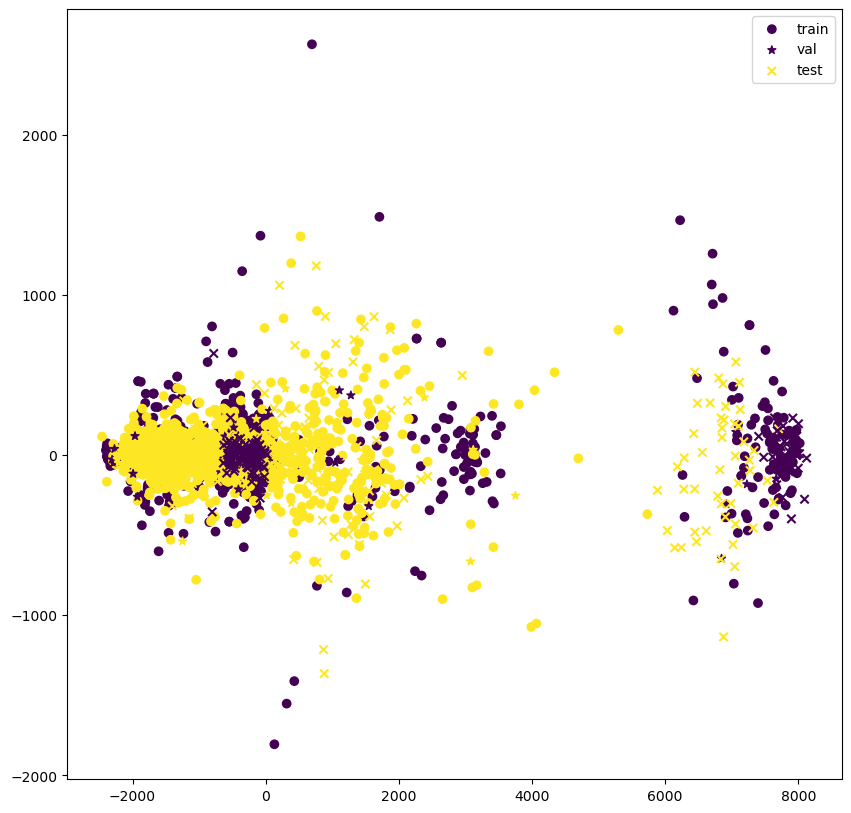

failed at: 0
train subs: [('non', 'af', '008'), ('non', 'af', '014'), ('non', 'af', '011'), ('non', 'af', '007'), ('non', 'af', '003'), ('non', 'af', '005'), ('non', 'af', '012'), ('non', 'af', '001'), ('non', 'af', '006'), ('non', 'af', '013'), ('non', 'af', '009'), ('non', 'af', '015'), ('af', '008'), ('af', '002'), ('af', '013'), ('af', '012'), ('af', '016'), ('af', '011'), ('af', '009'), ('af', '014'), ('af', '015'), ('af', '017'), ('af', '005'), ('af', '007'), ('af', '001'), ('af', '019')] test subs: [('af', '003'), ('af', '006'), ('af', '010'), ('af', '018'), ('non', 'af', '002'), ('non', 'af', '010'), ('non', 'af', '016')]
X_train shape:  (2600, 30, 59)  y_train shape:  (2600,)  X_val shape:  (123, 30, 59)  y_val shape:  (123,)  X_test shape:  (305, 30, 59)  y_test shape:  (305,)
train subs: [('non', 'af', '003'), ('non', 'af', '011'), ('non', 'af', '008'), ('non', 'af', '012'), ('non', 'af', '001'), ('non', 'af', '010'), ('non', 'af', '014'), ('non', 'af', '016'), ('non', 'af',

In [25]:

B = 100# 1000 10 cycle long samples for each subject
series_size = 30
fs = 125
add_hrv = True
add_morph = True


annot_files = sorted(glob.glob("/home/meiri.yoav/biomed_proj/data/annotated/*"))
af_files = [f for f in annot_files if 'non' not in f]
non_af_files = [f for f in annot_files if 'non' in f]

names = [tuple(f.split('/')[-1].split('.')[0].split('_')[1:]) for f in annot_files]


non_af_subs = [t  for t in list(names) if 'non' in t]
af_subs = [t  for t in list(names) if 'non' not in t]


different_train_test_split_num = 50
classification_resaults_arr = []
plot_pca_once = True
for train_split_config in range(different_train_test_split_num):
    try:
    # sample an array of indexes from 0 to len(non_af_subs) - 1, and take the first 80% of the indexes for the train subs and the last 20% for the test subs
        non_af_train_subs_idxs = np.random.choice(len(non_af_subs), int(len(non_af_subs)*0.8), replace=False)
        af_train_subs_idxs = np.random.choice(len(af_subs), int(len(af_subs)*0.8), replace=False)
        train_subs = [non_af_subs[i] for i in non_af_train_subs_idxs] + [af_subs[i] for i in af_train_subs_idxs]

        test_subs = [t for t in list(names) if t not in train_subs]
        # print train subs and test subs in the same line
        print('train subs: ' + str(train_subs) + ' test subs: ' + str(test_subs))
        subs_features = exctract_sub_features(train_subs, annot_files, add_hrv=add_hrv, add_morph=add_morph, B=B, series_size=series_size, fs=fs)
        X_train, y_train, X_val, y_val, X_test, y_test, train_subs, test_subs = create_dataset(subs_features, train_subs, test_subs)
        print('X_train shape: ', X_train.shape, ' y_train shape: ', y_train.shape, ' X_val shape: ', X_val.shape, ' y_val shape: ', y_val.shape, ' X_test shape: ', X_test.shape, ' y_test shape: ', y_test.shape)
        
        if plot_pca_once:
            plot_pca_once = False
            plot_pca(X_train, X_val, X_test, y_train, y_val, y_test, train_subs, test_subs)
        
        metrics, results = plot_classification_results(X_train, y_train, X_val, y_val, X_test, y_test, train_subs, test_subs)
        classification_resaults_arr.append(results)
    except:
        if plot_pca_once:
            plot_pca_once = False
            plot_pca(X_train, X_val, X_test, y_train, y_val, y_test, train_subs, test_subs)
        print('failed at: ' + str(train_split_config))
        train_split_config -= 1

# print("total number of train test splits: " + str(len(classification_resaults_arr)))
# train_subs = non_af_subs[:int(len(non_af_subs)*0.8)] + af_subs[:int(len(af_subs)*0.8)]

In [29]:
# # Create a dataframe which combines the results of all train test splits and compute the mean and std of each metric for each classifier
# classification_resaults_df = pd.concat(classification_resaults_arr)
# classification_resaults_df.groupby(['metric', 'classifier']).agg(['mean', 'std'])
# classification_resaults_df

In [30]:
flattened_results_dfs = list(map(lambda df: df.stack().reset_index().rename(columns={'level_0': 'partition'}), classification_resaults_arr))


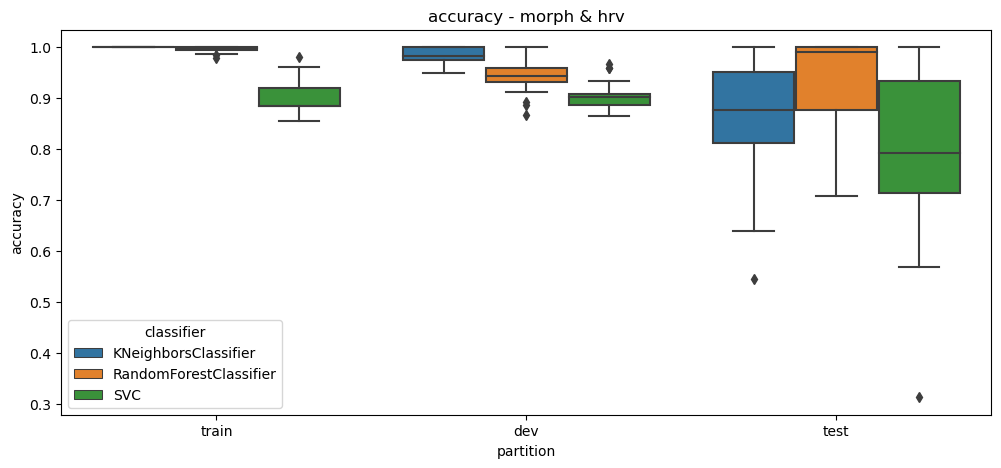

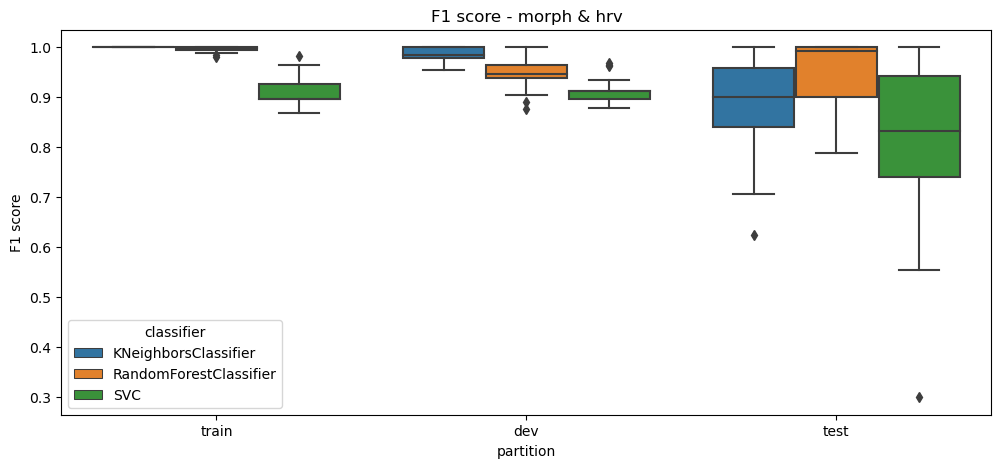

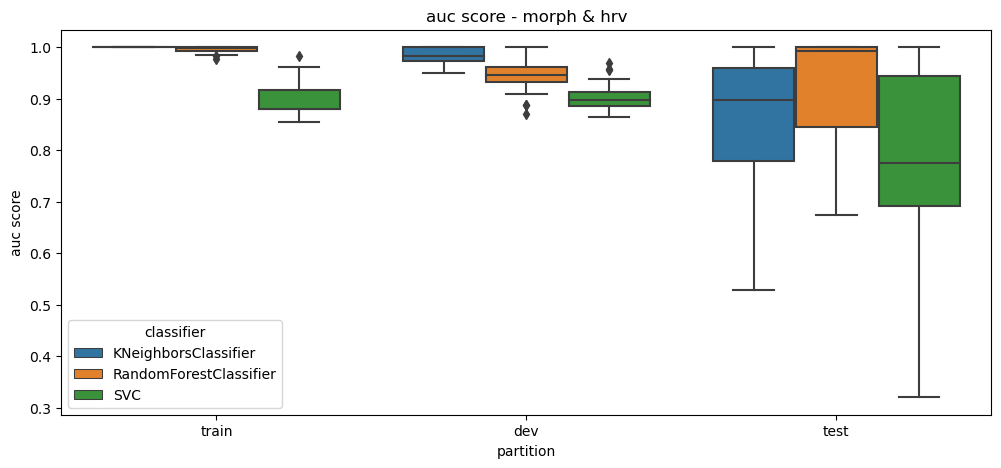

In [31]:
# stack the flattened results dataframes and create a boxplot where the x-axis is the partition, the y-axis is the score, and the hue is the classifier
flattened_results_df = pd.concat(flattened_results_dfs)

metrics = ['accuracy', 'F1 score', 'auc score']
for metric in metrics:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='partition', y=metric, hue='classifier', data=flattened_results_df)
    plt.title(metric + " - morph & hrv")
    plt.show()